In [1]:
#Data Preparation

import pandas as pd
import numpy as np

# Generate synthetic data
np.random.seed(42)
n_samples = 1000

income = np.random.normal(50, 15, n_samples).clip(20, 100).astype(int)  # Annual income ($k)
debt = np.random.normal(20, 5, n_samples).clip(5, 40).astype(int)        # Total debt ($k)
credit_history = np.random.choice(['poor', 'fair', 'good', 'excellent'], n_samples, p=[0.2, 0.3, 0.3, 0.2])

# Simulate creditworthiness (target variable)
prob = (
    0.3 * (income / 50) + 
    0.3 * (1 - debt / 30) + 
    0.4 * np.where(credit_history == 'excellent', 1, 
        np.where(credit_history == 'good', 0.8,
        np.where(credit_history == 'fair', 0.5, 0.3)))
)
creditworthy = (prob + np.random.normal(0, 0.1, n_samples)) > 0.5
creditworthy = creditworthy.astype(int)

df = pd.DataFrame({
    'income': income,
    'debt': debt,
    'credit_history': credit_history,
    'creditworthy': creditworthy
})

# Add debt-to-income ratio
df['debt_to_income'] = df['debt'] / (df['income'] + 1e-6)  # Avoid division by zero

In [2]:
#Preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Split data
X = df.drop('creditworthy', axis=1)
y = df['creditworthy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['income', 'debt', 'debt_to_income']),
    ('cat', OneHotEncoder(), ['credit_history'])
])

In [3]:
#Handle Class Imbalance

from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

In [4]:
from xgboost import XGBClassifier
print("XGBoost installed successfully!")

XGBoost installed successfully!


In [5]:
#Model Training

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_processed)
    results[name] = classification_report(y_test, y_pred, output_dict=True)

In [6]:
#Evaluation

from sklearn.metrics import classification_report, roc_auc_score

for name, report in results.items():
    print(f"**{name}**")
    print(classification_report(y_test, model.predict(X_test_processed)))
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.2f}\n")

**Logistic Regression**
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        37
           1       0.91      0.92      0.92       163

    accuracy                           0.86       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.86      0.86      0.86       200

ROC-AUC: 0.85

**Random Forest**
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        37
           1       0.91      0.92      0.92       163

    accuracy                           0.86       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.86      0.86      0.86       200

ROC-AUC: 0.85

**XGBoost**
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        37
           1       0.91      0.92      0.92       163

    accuracy                           0.86       200
   macro avg       0.78      0.77      0.77 

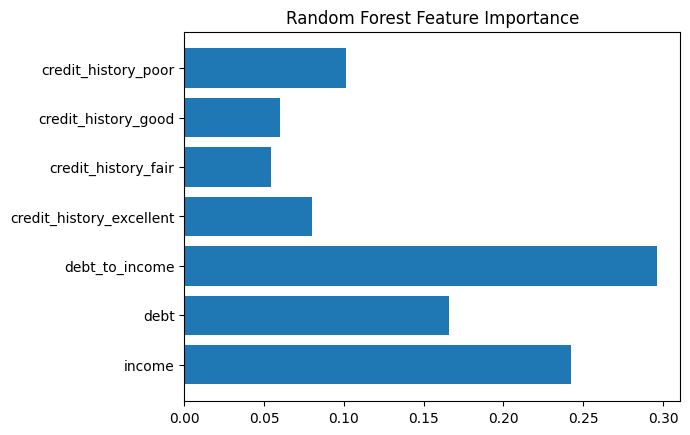

In [7]:
#Random Forest Importance

import matplotlib.pyplot as plt

# Extract feature names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['credit_history'])
num_features = ['income', 'debt', 'debt_to_income']
all_features = np.concatenate([num_features, cat_features])

# Plot importance
rf = models['Random Forest']
plt.barh(all_features, rf.feature_importances_)
plt.title('Random Forest Feature Importance')
plt.show()

In [8]:
#Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train_res, y_train_res)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [9]:
#save the Model

import joblib

joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(models['XGBoost'], 'credit_scoring_model.joblib')

['credit_scoring_model.joblib']